# Startup Investments

В проекте проведен анализ данных о фондах и инвестициях https://www.kaggle.com/datasets/justinas/startup-investments. 
Схема базы данных приведена ниже. Представлены наиболее сложные запросы в проекте. 

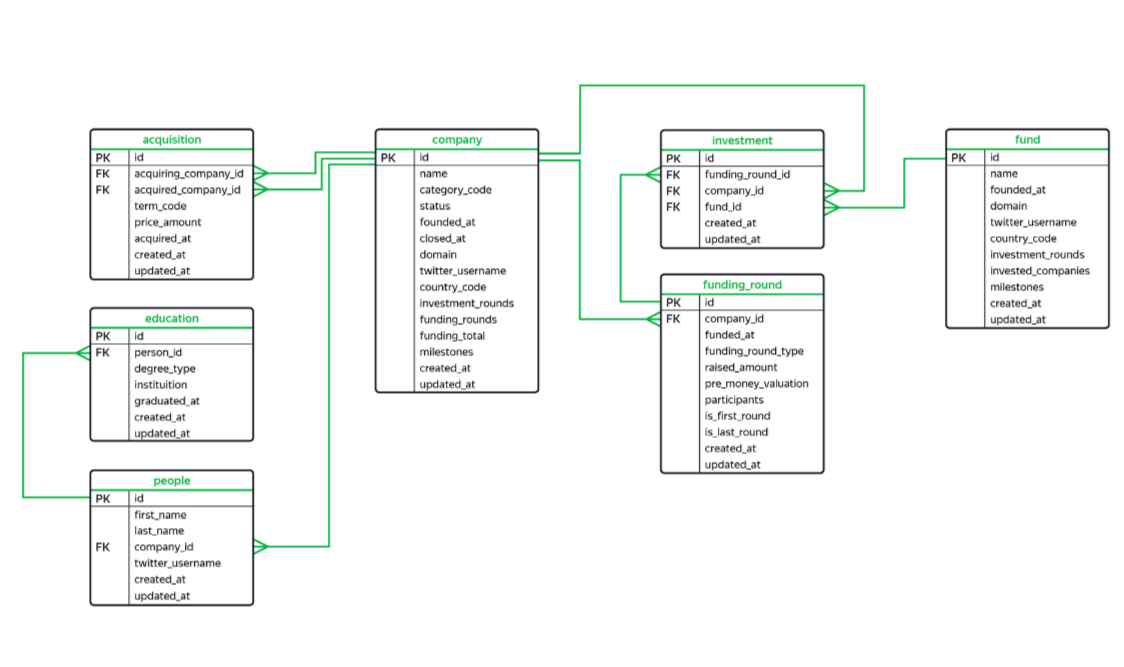

In [2]:
from IPython.display import Image
Image(filename="./db.png")

Составляется сводная таблица и выведится среднюя сумму инвестиций для стран, в которых есть стартапы, зарегистрированные в 2011, 2012 и 2013 годах. Данные за каждый год приведены в отдельном поле.  Таблица отсортирована по среднему значению инвестиций за 2011 год от большего к меньшему.

~~~sql
WITH 
y2011 AS (SELECT country_code AS country,
                 AVG(funding_total) AS avg_inv_2011
          FROM company
          WHERE EXTRACT(YEAR FROM founded_at) = 2011
          GROUP BY country_code
          ),
y2012 AS (SELECT country_code AS country,
                 AVG(funding_total) AS avg_inv_2012
          FROM company
          WHERE EXTRACT(YEAR FROM founded_at) = 2012
          GROUP BY country_code
          ),
y2013 AS (SELECT country_code AS country,
                 AVG(funding_total) AS avg_inv_2013
          FROM company
          WHERE EXTRACT(YEAR FROM founded_at) = 2013
          GROUP BY country_code
          )
          

SELECT y2011.country,
       avg_inv_2011,
       avg_inv_2012,
       avg_inv_2013
FROM y2011
INNER JOIN y2012 ON y2011.country=y2012.country
INNER JOIN y2013 ON y2011.country=y2013.country
ORDER BY avg_inv_2011 DESC
;
~~~

Отобраны данные по месяцам с 2010 по 2013 год, когда проходили инвестиционные раунды. Сгруппированны данные по номеру месяца и получите таблицу, с полями:
- номер месяца, в котором проходили раунды;
- количество уникальных названий фондов из США, которые инвестировали в этом месяце;
- количество компаний, купленных за этот месяц;
- общая сумма сделок по покупкам в этом месяце.

~~~sql
WITH 
funds_dist AS (SELECT EXTRACT(MONTH FROM fr.funded_at) AS month,
                      COUNT(DISTINCT f.name) as count_funds
               FROM funding_round AS fr
               LEFT OUTER JOIN investment AS inv ON fr.id=inv.funding_round_id 
               LEFT OUTER JOIN fund AS f ON f.id=inv.fund_id 
               WHERE EXTRACT(YEAR FROM funded_at) BETWEEN 2010 AND 2013
                 AND f.country_code LIKE 'USA'
               GROUP BY month
               ),
               
comp_dist AS (SELECT EXTRACT(MONTH FROM a.acquired_at) AS month,
                     COUNT(a.acquired_company_id) as count_comp,
                     SUM(a.price_amount) as total_price
              FROM acquisition AS a
              WHERE EXTRACT(YEAR FROM a.acquired_at) BETWEEN 2010 AND 2013
              GROUP BY month
              )

SELECT fd.month,
       fd.count_funds,
       cd.count_comp,
       cd.total_price
FROM funds_dist AS fd
INNER JOIN comp_dist AS cd ON fd.month=cd.month
;
~~~



Выгружается таблица, в которую входят названия компаний из категории social, получившие финансирование с 2010 по 2013 год включительно. Исключены записи с нулевой суммой инвестиций. Выведен также номер месяца, в котором проходил раунд финансирования.

~~~sql
SELECT c.name,
       --CAST(DATE_TRUNC('month',fr.funded_at)-- AS date)
       EXTRACT(MONTH FROM fr.funded_at)
FROM company AS c
LEFT OUTER JOIN funding_round AS fr ON fr.company_id=c.id
WHERE category_code LIKE 'social'
  AND EXTRACT(YEAR FROM fr.funded_at) BETWEEN 2010 AND 2013
  AND fr.raised_amount <> 0
;
~~~

Выгружается таблица с полями:
- название компании-покупателя;
- сумма сделки;
- название компании, которую купили;
- сумма инвестиций, вложенных в купленную компанию;
- доля, которая отображает, во сколько раз сумма покупки превысила сумму вложенных в компанию инвестиций, округлённая до ближайшего целого числа.
Не учитываются сделки, в которых сумма покупки равна нулю. 
Таблица отсортирована по сумме сделки от большей к меньшей, а затем по названию купленной компании в лексикографическом порядке. Таблица представлена первыми десятью записями.

~~~sql
WITH acquired_companies AS 
        (SELECT a.acquired_company_id AS acquired_company_id,
                c.name AS acquired_company_name,
                c.funding_total AS funding_total
        FROM acquisition AS a
        LEFT OUTER JOIN company AS c ON c.id=a.acquired_company_id
        WHERE funding_total <> 0
        )

SELECT DISTINCT c.name AS acquiring_company_name,
       a.price_amount,
       ac.acquired_company_name AS acquired_company_name,
       ac.funding_total,
       ROUND(a.price_amount/ac.funding_total) as exceed_fraction
FROM acquisition AS a
LEFT OUTER JOIN company AS c ON c.id=a.acquiring_company_id
LEFT OUTER JOIN acquired_companies AS ac ON ac.acquired_company_id=a.acquired_company_id
WHERE a.price_amount <> 0
  AND  ac.funding_total IS NOT NULL
ORDER BY a.price_amount DESC, ac.acquired_company_name
LIMIT 10
;  
~~~